In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


In [50]:
# Load the dataset
df = pd.read_csv('tlkm.csv', parse_dates=['Tanggal'])
df.rename(columns={'Perubahan%':'Perubahan','Vol.':'Vol'}, inplace=True)

df['Vol'] = df['Vol'].str.replace('M','')
df['Vol'] = df['Vol'].str.replace(',','.')
df['Vol'] = df['Vol'].astype(float)*1000000

multiply_byk = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']
for col in multiply_byk:
    df[col] = df[col]*1000

df['Perubahan'] = df['Perubahan'].str.replace('%','')
df['Perubahan'] = df['Perubahan'].str.replace(',','.')
df['Perubahan'] = df['Perubahan'].astype(float)

#reverse the order of rows and reset the index
df = df[::-1].reset_index(drop=True)

df

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol,Perubahan
0,2020-02-01,3910.0,3970.0,4000.0,3900.0,52090000.0,-1.51
1,2020-03-01,3980.0,3960.0,3980.0,3930.0,70030000.0,1.79
2,2020-06-01,3960.0,3930.0,3970.0,3930.0,42910000.0,-0.50
3,2020-07-01,3940.0,3930.0,3970.0,3920.0,51840000.0,-0.51
4,2020-08-01,3900.0,3920.0,3950.0,3900.0,52400000.0,-1.02
...,...,...,...,...,...,...,...
794,2023-03-29,4100.0,4090.0,4120.0,4070.0,88350000.0,1.23
795,2023-03-30,4090.0,4050.0,4130.0,4040.0,87710000.0,-0.24
796,2023-03-31,4060.0,4110.0,4120.0,4040.0,93750000.0,-0.73
797,2023-03-04,4080.0,4100.0,4100.0,4070.0,48050000.0,0.49


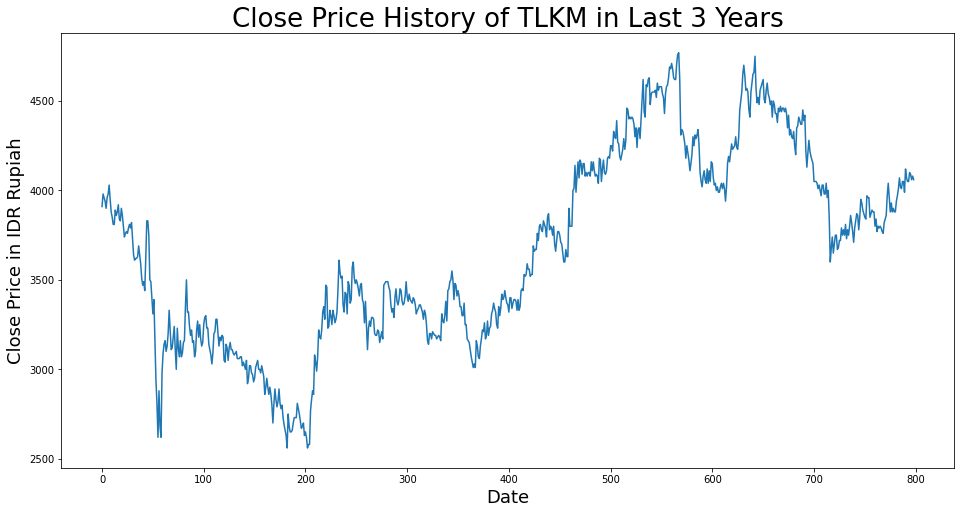

In [54]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History of TLKM in Last 3 Years', fontsize=26)
plt.plot(df['Terakhir'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in IDR Rupiah', fontsize=18)
plt.show()

In [4]:
# Extract the relevant features
X = df[['Pembukaan','Tertinggi','Terendah','Vol']]
y = df[['Terakhir']]

# Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Reshape the data into 3D
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1],1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))


In [5]:
# Build the model and name it LSTM Model predictor
model = Sequential(name='LSTM_Model_Predictor')
model.add(LSTM(100, return_sequences=True, input_shape=(train_X.shape[1],1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()


Model: "LSTM_Model_Predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 25)                2525      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model validate the model save the history
history = model.fit(train_X, train_y, batch_size=1, epochs=50, validation_data=(test_X, test_y))

Epoch 1/50
639/639 [==============================] - 7s 8ms/step - loss: 0.0013 - val_loss: 3.4018e-04
Epoch 2/50
639/639 [==============================] - 4s 7ms/step - loss: 0.0010 - val_loss: 3.3127e-04
Epoch 3/50
639/639 [==============================] - 4s 7ms/step - loss: 9.1286e-04 - val_loss: 7.7964e-04
Epoch 4/50
639/639 [==============================] - 5s 7ms/step - loss: 8.8152e-04 - val_loss: 3.3416e-04
Epoch 5/50
639/639 [==============================] - 4s 7ms/step - loss: 8.3256e-04 - val_loss: 0.0049
Epoch 6/50
639/639 [==============================] - 4s 7ms/step - loss: 7.1750e-04 - val_loss: 2.8569e-04
Epoch 7/50
639/639 [==============================] - 4s 7ms/step - loss: 8.3300e-04 - val_loss: 3.2494e-04
Epoch 8/50
639/639 [==============================] - 4s 7ms/step - loss: 6.7107e-04 - val_loss: 6.3196e-04
Epoch 9/50
639/639 [==============================] - 4s 7ms/step - loss: 7.1510e-04 - val_loss: 0.0014
Epoch 10/50
639/639 [=======================

In [8]:
#save the model
model.save('LSTM_Stock_Predictor_Indonesia.h5')

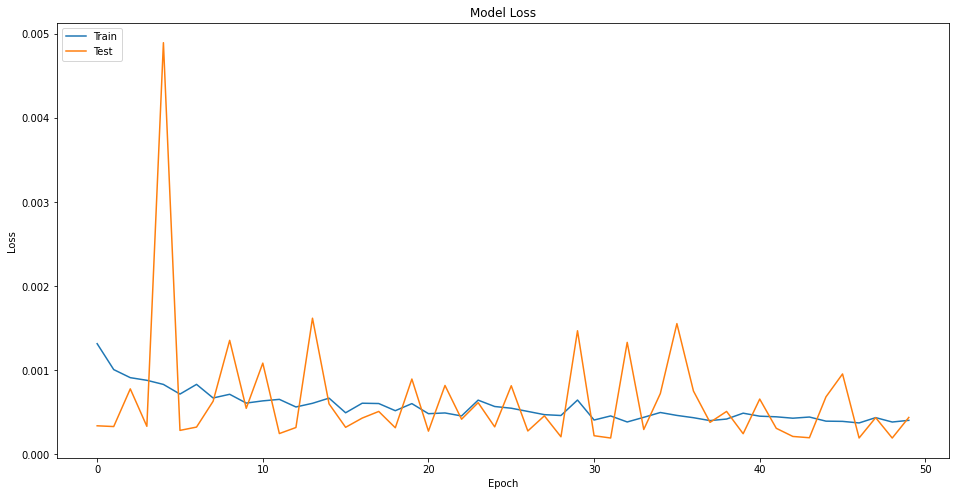

In [9]:
# Visualize the loss history
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
# Make predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# Invert the normalization
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
train_y = scaler.inverse_transform(train_y)
test_y = scaler.inverse_transform(test_y)


In [11]:
# MEA between test_predict and test_actual
mea_list = []
test_actual = df['Terakhir'][train_size:]
for i in range(len(test_predict)):
    mea_list.append(abs(test_predict[i][0] - test_actual.iloc[i]))
mea = sum(mea_list)/len(mea_list)
print('Mean Error Average: ', mea)

Mean Error Average:  35.881715393066415


In [12]:
# MEA between train_predict and train_actual
mea_list = []
train_actual = df['Terakhir'][:train_size]
for i in range(len(train_predict)):
    mea_list.append(train_actual[i] - train_predict[i][0])

mea = sum(mea_list)/len(mea_list)
print('Mean Error Average: ', mea)

Mean Error Average:  11.775789884707551


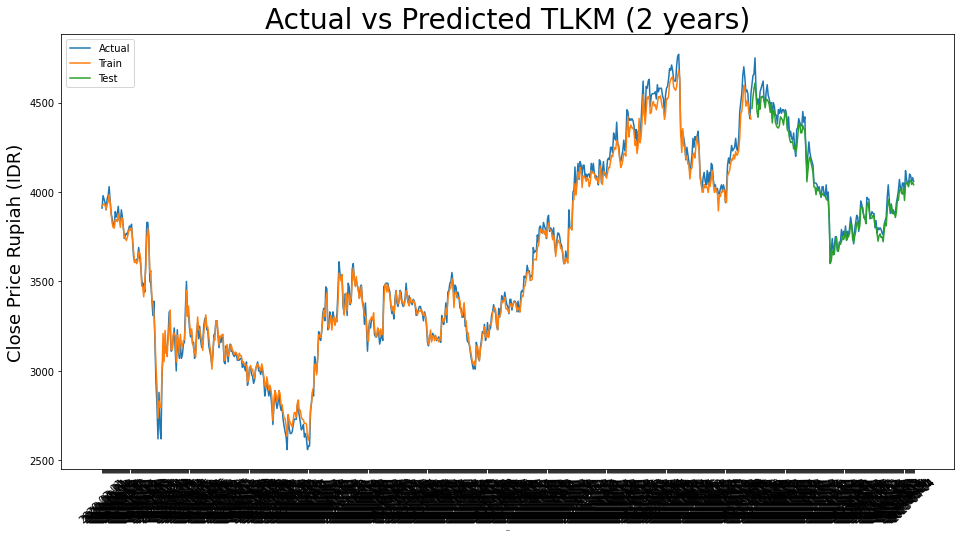

In [13]:
# Plot the results
plt.figure(figsize=(16,8))
plt.plot(df['Tanggal'].astype(str), (df[['Terakhir']]))
plt.plot(df['Tanggal'][:train_size].astype(str), train_predict)
plt.plot(df['Tanggal'][train_size:].astype(str), test_predict)
plt.legend(['Actual', 'Train', 'Test'], loc='upper left')

plt.xlabel('Date', fontsize=2)
plt.xticks(rotation=45)
plt.ylabel('Close Price Rupiah (IDR)', fontsize=18)
plt.title('Actual vs Predicted TLKM (2 years)', fontsize=28)
plt.show()

# The Model on Other Data (BMRI)

In [25]:
test_dataset = pd.read_csv('bmri.csv', parse_dates=['Tanggal'], date_parser=lambda x: pd.datetime.strptime(x, '%d/%m/%Y'))
test_dataset.rename(columns={'Perubahan%':'Perubahan','Vol.':'Vol'}, inplace=True)

multiply_byk = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']
for col in multiply_byk:
    test_dataset[col] = test_dataset[col]*1000

# eliminate first row and reverse the order
test_dataset = test_dataset.iloc[1:][::-1]
test_dataset = test_dataset.reset_index(drop=True)

test_dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol,Perubahan
0,2023-03-06,10125.0,10175.0,10225.0,10075.0,2692000000,0.75
1,2023-03-07,10175.0,10150.0,10275.0,10125.0,3524000000,0.49
2,2023-03-08,10275.0,10250.0,10275.0,10175.0,4393000000,0.98
3,2023-03-09,10450.0,10400.0,10500.0,10350.0,4164000000,1.70
4,2023-03-10,10375.0,10425.0,10425.0,10275.0,5571000000,-0.72
5,2023-03-13,10350.0,10275.0,10375.0,10225.0,4641000000,-0.24
6,2023-03-14,9925.0,10200.0,10275.0,9850.0,9638000000,-4.11
7,2023-03-15,10050.0,10050.0,10175.0,9850.0,11662000000,1.26
8,2023-03-16,9850.0,10075.0,10075.0,9825.0,6245000000,-1.99
9,2023-03-17,10100.0,9950.0,10125.0,9925.0,8783000000,2.54


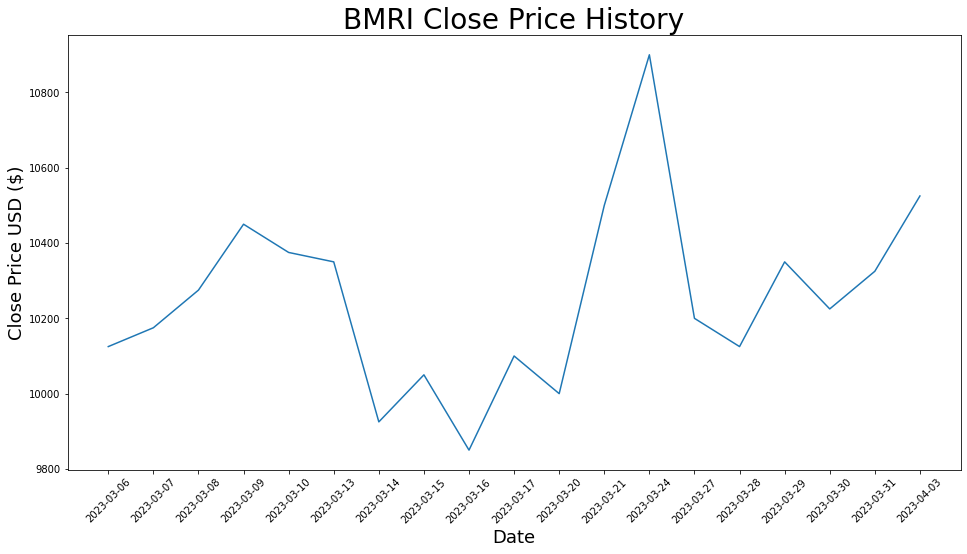

In [26]:
#visualize the closing price history
plt.figure(figsize=(16,8))
plt.plot(test_dataset['Tanggal'].astype(str), (test_dataset[['Terakhir']]))
plt.xlabel('Date', fontsize=18)
plt.xticks(rotation=45)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.title('BMRI Close Price History', fontsize=28)
plt.show()


In [27]:
predict_X = test_dataset[['Pembukaan','Tertinggi','Terendah','Vol']]
predict_y = test_dataset[['Terakhir']]

new_scaler = MinMaxScaler()
predict_X = new_scaler.fit_transform(predict_X)
predict_y = new_scaler.fit_transform(predict_y)

predict_X = np.reshape(predict_X, (predict_X.shape[0], predict_X.shape[1], 1))

In [28]:
predicted_y = model.predict(predict_X)
predicted_y = new_scaler.inverse_transform(predicted_y)

In [29]:
#count mean absolute error between predicted and actual
test_dataset['Predicted'] = predicted_y
test_dataset['MAE'] = abs(test_dataset['Predicted'] - test_dataset['Terakhir'])
test_dataset['MAE'].mean()

72.42552425986842

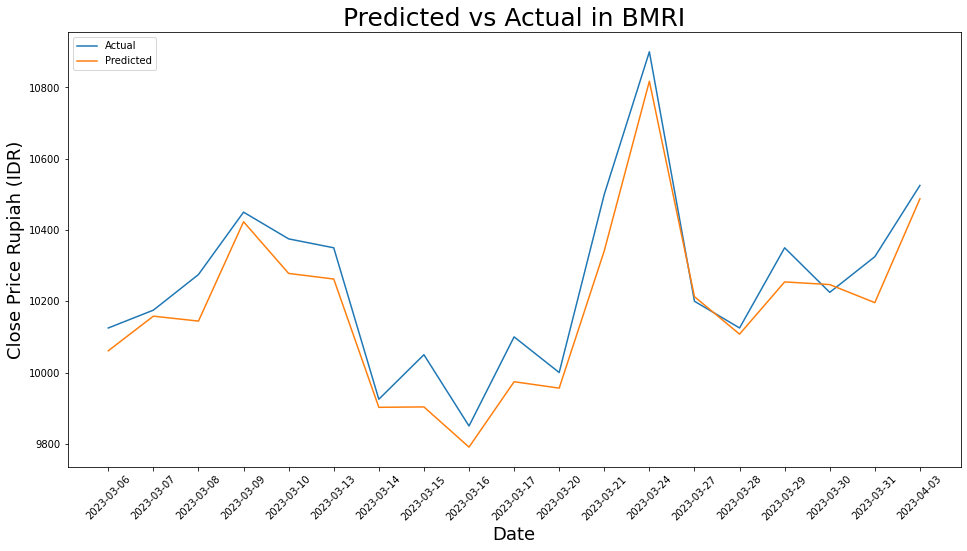

In [30]:
plt.figure(figsize=(16,8))
plt.plot(test_dataset['Tanggal'].astype(str), (test_dataset[['Terakhir']]))
plt.plot(test_dataset['Tanggal'].astype(str), predicted_y)
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.xlabel('Date', fontsize=18)
plt.xticks(rotation=45)
plt.ylabel('Close Price Rupiah (IDR)', fontsize=18)
plt.title('Predicted vs Actual in BMRI', fontsize=25)
plt.show()


# The Model on Other Data (MYOR)

In [43]:
# Load the dataset
test_predict = pd.read_csv('myor.csv', parse_dates=['Tanggal'])
test_predict.rename(columns={'Perubahan%':'Perubahan','Vol.':'Vol'}, inplace=True)

for i in range(len(test_predict)):
    vol_temp = test_predict['Vol'][i]
    # replace of comma with dot of the volume in iloc i
    vol_temp = vol_temp.replace(',','.')
    if vol_temp[-1] == 'K':
        vol_temp = vol_temp.replace('K','')
        vol_temp = float(vol_temp)*1000
    elif vol_temp[-1] == 'M':
        vol_temp = vol_temp.replace('M','')
        vol_temp = float(vol_temp)*1000000

    test_predict['Vol'][i] = vol_temp


multiply_byk = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']
for col in multiply_byk:
    test_predict[col] = test_predict[col]*1000

test_predict['Perubahan'] = test_predict['Perubahan'].str.replace('%','')
test_predict['Perubahan'] = test_predict['Perubahan'].str.replace(',','.')
test_predict['Perubahan'] = test_predict['Perubahan'].astype(float)

#reverse the order of rows and reset the index
test_predict = test_predict[::-1].reset_index(drop=True)

test_predict

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol,Perubahan
0,2019-02-01,2650.0,2620.0,2650.0,2620.0,869900,1.15
1,2019-03-01,2620.0,2650.0,2660.0,2610.0,748800,-1.13
2,2019-04-01,2640.0,2620.0,2660.0,2600.0,1.28e+06,0.76
3,2019-07-01,2710.0,2650.0,2730.0,2640.0,1.67e+06,2.65
4,2019-08-01,2630.0,2710.0,2750.0,2600.0,1.75e+06,-2.95
...,...,...,...,...,...,...,...
1040,2023-03-30,2670.0,2740.0,2740.0,2670.0,4.67e+06,-2.55
1041,2023-03-31,2670.0,2670.0,2720.0,2570.0,1.144e+07,0.00
1042,2023-03-04,2640.0,2680.0,2690.0,2630.0,2.25e+06,-1.12
1043,2023-04-04,2610.0,2640.0,2670.0,2580.0,4.54e+06,-1.14


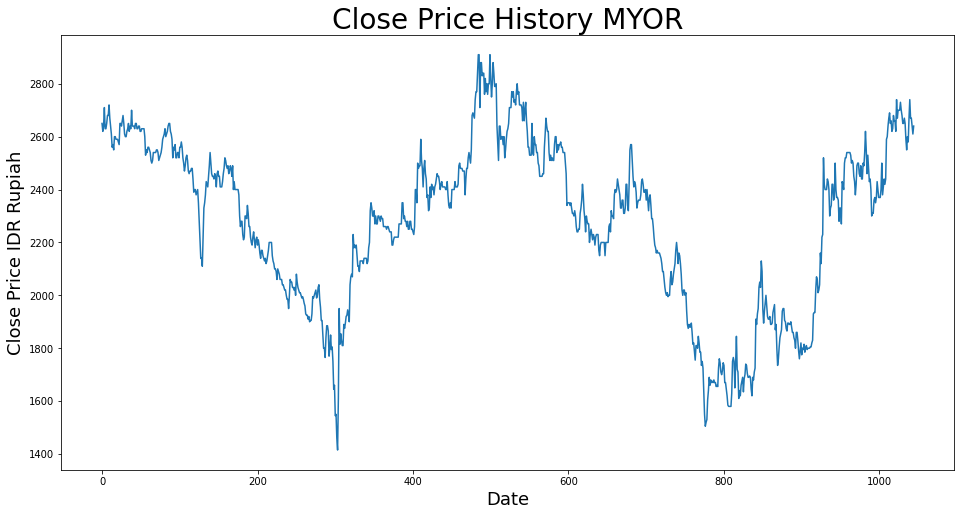

In [55]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History MYOR', fontsize=28)
plt.plot(test_predict['Terakhir'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price IDR Rupiah', fontsize=18)
plt.show()

In [45]:
predict_X = test_predict[['Pembukaan','Tertinggi','Terendah','Vol']]
predict_y = test_predict[['Terakhir']]

new_scaler = MinMaxScaler()
predict_X = new_scaler.fit_transform(predict_X)
predict_y = new_scaler.fit_transform(predict_y)

predict_X = np.reshape(predict_X, (predict_X.shape[0], predict_X.shape[1], 1))

In [46]:
predicted_y = model.predict(predict_X)
predicted_y = new_scaler.inverse_transform(predicted_y)

In [48]:
#count mean absolute error between predicted and actual
test_predict['Predicted'] = predicted_y
test_predict['MAE'] = abs(test_predict['Predicted'] - test_predict['Terakhir'])
test_predict['MAE'].mean()

23.60061922940341

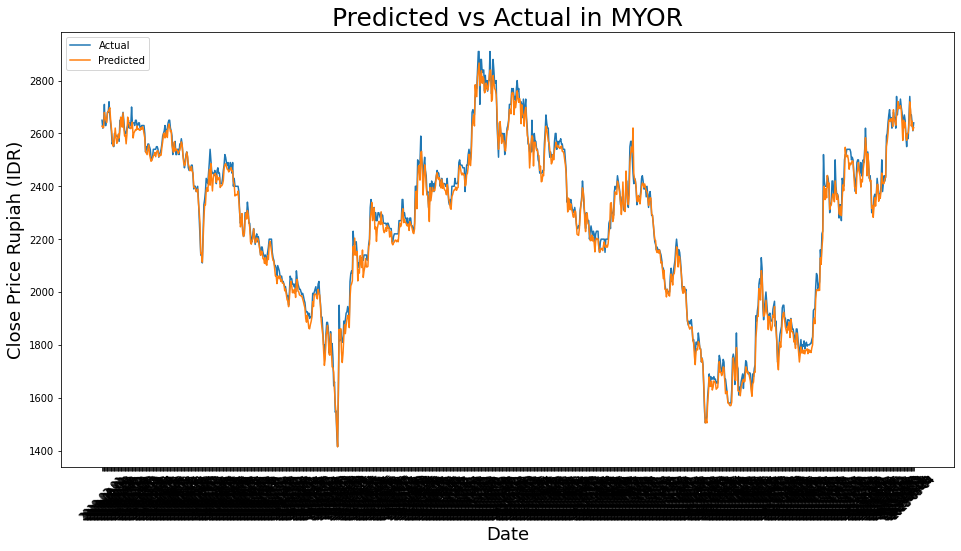

In [49]:
plt.figure(figsize=(16,8))
plt.plot(test_predict['Tanggal'].astype(str), (test_predict[['Terakhir']]))
plt.plot(test_predict['Tanggal'].astype(str), predicted_y)
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.xlabel('Date', fontsize=18)
plt.xticks(rotation=45)
plt.ylabel('Close Price Rupiah (IDR)', fontsize=18)
plt.title('Predicted vs Actual in MYOR', fontsize=25)
plt.show()
